# House price Kaggle with XGBoost, LightGBM and CatBoost

- data exploration to understand which features are more relevant to predict house price
- data preprocessing (missing values, one-hot-encoding, scaling) and model definition through ColumnTransformer and Pipeline
- Fitting of the model and evaluation (train set split in training and validation): LinearRegression, XGBoost, LightGBM, CatBoost
- predicting house price for test set (unlabelled) given and generate submission file

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [110]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [111]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [112]:
train.isnull().sum()[train.isnull().sum()>0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [113]:
train = train.drop(columns = ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis = 1)
test = test.drop(columns = ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis = 1)

In [114]:
train.isnull().sum()[train.isnull().sum()>0].index

Index(['LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual',
       'GarageCond'],
      dtype='object')

In [115]:
train[['SalePrice','LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual',
       'GarageCond']].corr()

,SalePrice,LotFrontage,MasVnrArea,GarageYrBlt
SalePrice,1.000000,0.351799,0.477493,0.486362
LotFrontage,0.351799,1.000000,0.193458,0.070250
MasVnrArea,0.477493,0.193458,1.000000,0.252691
GarageYrBlt,0.486362,0.070250,0.252691,1.000000


In [116]:
train[['LotFrontage', 'MasVnrArea','GarageYrBlt']].describe()

,LotFrontage,MasVnrArea,GarageYrBlt
count,1201.000000,1452.000000,1379.000000
mean,70.049958,103.685262,1978.506164
std,24.284752,181.066207,24.689725
min,21.000000,0.000000,1900.000000
25%,59.000000,0.000000,1961.000000
50%,69.000000,0.000000,1980.000000
75%,80.000000,166.000000,2002.000000
max,313.000000,1600.000000,2010.000000


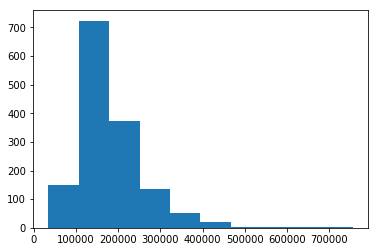

In [117]:
plt.hist(train.SalePrice)
plt.show()

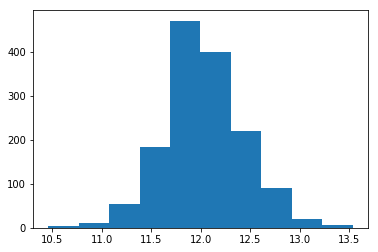

In [118]:
plt.hist(np.log(train.SalePrice))
plt.show()

In [119]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPo

In [120]:
corr = train[['SalePrice','Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition']].corr()
corr.style.background_gradient(cmap='coolwarm')

,SalePrice,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
SalePrice,1.000000,-0.021917,-0.084284,0.351799,0.263843,0.790982,-0.077856,0.522897,0.507101,0.477493,0.386420,-0.011378,0.214479,0.613581,0.605852,0.319334,-0.025606,0.708624,0.227122,-0.016844,0.560664,0.284108,0.168213,-0.135907,0.533723,0.466929,0.486362,0.640409,0.623431,0.324413,0.315856,-0.128578,0.044584,0.111447,0.092404,-0.021190,0.046432,-0.028923
Id,-0.021917,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,-0.005968,-0.007940,-0.015415,0.010496,0.005590,-0.044230,0.008273,0.002289,-0.020155,0.005587,0.006784,0.037719,0.002951,0.027239,-0.019772,0.000072,0.016570,0.017634,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712
MSSubClass,-0.084284,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,0.085072,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407
LotFrontage,0.351799,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,0.132644,0.392075,0.457181,0.080177,0.038469,0.402797,0.100949,-0.007234,0.198769,0.053532,0.263170,-0.006069,0.352096,0.266639,0.070250,0.285691,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450
LotArea,0.263843,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,-0.024947,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261
OverallQual,0.790982,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.547766,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347
OverallCond,-0.077856,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.324297,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950
YearBuilt,0.522897,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.825667,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618
YearRemodAdd,0.507101,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.642277,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743
MasVnrArea,0.477493,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,0.114442,0.363936,0.344501,0.174561,-0.069071,0.390857,0.085310,0.026673,0.276833,0.201444,0.102821,-0.037610,0.280682,0.249070,0.252691,0.364204,0.373066,0.159718,0.125703,-0.110204,0.0

In [121]:
num_features = ['LotFrontage', 'LotArea', 'OverallQual','YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 
'2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 
'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea','WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch']

In [122]:
corr = train[['SalePrice']+num_features].corr()
corr.style.background_gradient(cmap='coolwarm')

,SalePrice,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch
SalePrice,1.000000,0.351799,0.263843,0.790982,0.522897,0.507101,0.477493,0.386420,0.214479,0.613581,0.605852,0.319334,0.708624,0.227122,0.560664,0.284108,0.168213,-0.135907,0.533723,0.466929,0.486362,0.640409,0.623431,0.324413,0.315856,-0.128578
LotFrontage,0.351799,1.000000,0.426095,0.251646,0.123349,0.088866,0.193458,0.233633,0.132644,0.392075,0.457181,0.080177,0.402797,0.100949,0.198769,0.053532,0.263170,-0.006069,0.352096,0.266639,0.070250,0.285691,0.344997,0.088521,0.151972,0.010700
LotArea,0.263843,0.426095,1.000000,0.105806,0.014228,0.013788,0.104160,0.214103,-0.002618,0.260833,0.299475,0.050986,0.263116,0.158155,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,-0.024947,0.154871,0.180403,0.171698,0.084774,-0.018340
OverallQual,0.790982,0.251646,0.105806,1.000000,0.572323,0.550684,0.411876,0.239666,0.308159,0.537808,0.476224,0.295493,0.593007,0.111098,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.547766,0.600671,0.562022,0.238923,0.308819,-0.113937
YearBuilt,0.522897,0.123349,0.014228,0.572323,1.000000,0.592855,0.315707,0.249503,0.149040,0.391452,0.281986,0.010308,0.199010,0.187599,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.825667,0.537850,0.478954,0.224880,0.188686,-0.387268
YearRemodAdd,0.507101,0.088866,0.013788,0.550684,0.592855,1.000000,0.179618,0.128451,0.181133,0.291066,0.240379,0.140024,0.287389,0.119470,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.642277,0.420622,0.371600,0.205726,0.226298,-0.193919
MasVnrArea,0.477493,0.193458,0.104160,0.411876,0.315707,0.179618,1.000000,0.264736,0.114442,0.363936,0.344501,0.174561,0.390857,0.085310,0.276833,0.201444,0.102821,-0.037610,0.280682,0.249070,0.252691,0.364204,0.373066,0.159718,0.125703,-0.110204
BsmtFinSF1,0.386420,0.233633,0.214103,0.239666,0.249503,0.128451,0.264736,1.000000,-0.495251,0.522396,0.445863,-0.137079,0.208171,0.649212,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.153484,0.224054,0.296970,0.204306,0.111761,-0.102303
BsmtUnfSF,0.214479,0.132644,-0.002618,0.308159,0.149040,0.181133,0.114442,-0.495251,1.000000,0.415360,0.317987,0.004469,0.240257,-0.422900,0.288886,-0.041118,0.166643,0.030086,0.250647,0.051575,0.190708,0.214175,0.183303,-0.005316,0.129005,-0.002538
TotalBsmtSF,0.613581,0.392075,0.260833,0.537808,0.391452,0.291066,0.363936,0.522396,0.415360,1.000000,0.819530,-0.174512,0.454868,0.307351,0.323722,-0.048804,0.050450,-0.068901,0.285573,0.339519,0.322445,0.434585,0.486665,0.232019,0.247264,-0.095478


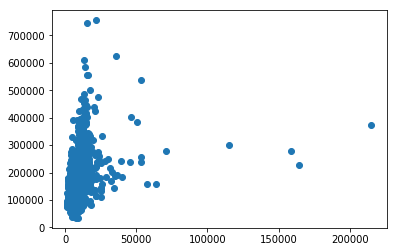

In [123]:
plt.scatter(train['LotArea'], train['SalePrice']) #we can take this out
plt.show()

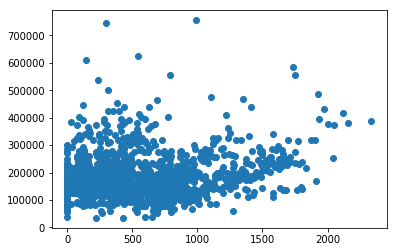

In [124]:
plt.scatter(train['BsmtUnfSF'], train['SalePrice']) #we can take this out
plt.show()

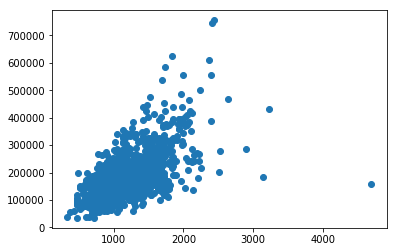

In [125]:
plt.scatter(train['1stFlrSF'], train['SalePrice'])
plt.show()

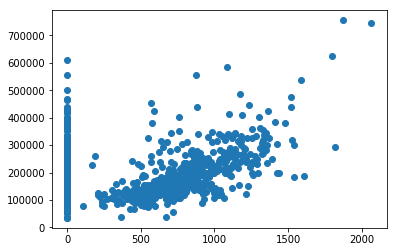

In [126]:
plt.scatter(train['2ndFlrSF'], train['SalePrice'])
plt.show()

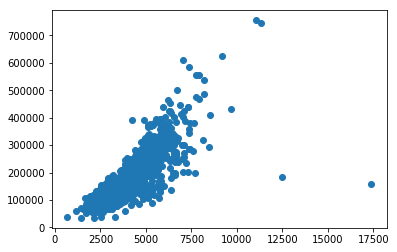

In [127]:
train['totSF'] = train['1stFlrSF'] + train['2ndFlrSF'] + train['GrLivArea'] + train['TotalBsmtSF']
test['totSF'] = test['1stFlrSF'] + test['2ndFlrSF'] + test['GrLivArea'] + test['TotalBsmtSF']
plt.scatter(train['totSF'], train['SalePrice'])
plt.show()

In [128]:
train[['SalePrice','1stFlrSF','2ndFlrSF','GrLivArea','TotalBsmtSF','totSF']].corr()

,SalePrice,1stFlrSF,2ndFlrSF,GrLivArea,TotalBsmtSF,totSF
SalePrice,1.000000,0.605852,0.319334,0.708624,0.613581,0.777123
1stFlrSF,0.605852,1.000000,-0.202646,0.566024,0.819530,0.731139
2ndFlrSF,0.319334,-0.202646,1.000000,0.687501,-0.174512,0.492148
GrLivArea,0.708624,0.566024,0.687501,1.000000,0.454868,0.952275
TotalBsmtSF,0.613581,0.819530,-0.174512,0.454868,1.000000,0.703027
totSF,0.777123,0.731139,0.492148,0.952275,0.703027,1.000000


In [129]:
train[['BsmtFullBath', 'FullBath', 'HalfBath']].value_counts() #they are count (num) of bathrooms at the different levels

BsmtFullBath  FullBath  HalfBath
0             2         0           256
              1         0           255
1             1         0           210
0             2         1           207
1             2         0           168
                        1           126
0             1         1           110
1             1         1            68
0             3         1            13
                        0             8
1             3         0             6
                        1             5
2             2         0             5
0             1         2             3
              2         2             3
2             0         1             2
                        2             2
              1         1             2
1             0         0             2
3             3         0             1
1             1         2             1
              0         1             1
2             2         2             1
1             2         2             1
2      

In [130]:
train['totBath'] = train['BsmtFullBath'] + train['FullBath'] + train['HalfBath']
test['totBath'] = test['BsmtFullBath'] + test['FullBath'] + test['HalfBath']

In [131]:
train[['SalePrice','totBath','BsmtFullBath','FullBath','HalfBath']].corr()

,SalePrice,totBath,BsmtFullBath,FullBath,HalfBath
SalePrice,1.000000,0.618474,0.227122,0.560664,0.284108
totBath,0.618474,1.000000,0.507962,0.636297,0.610194
BsmtFullBath,0.227122,0.507962,1.000000,-0.064512,-0.030905
FullBath,0.560664,0.636297,-0.064512,1.000000,0.136381
HalfBath,0.284108,0.610194,-0.030905,0.136381,1.000000


In [132]:
num_features = ['LotFrontage', 'LotArea', 'OverallQual','YearBuilt', 'YearRemodAdd', 'MasVnrArea','totSF', 'totBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 
'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea','WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch']

In [133]:
corr = train[['SalePrice']+num_features].corr()
corr.style.background_gradient(cmap='coolwarm')

,SalePrice,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,totSF,totBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch
SalePrice,1.000000,0.351799,0.263843,0.790982,0.522897,0.507101,0.477493,0.777123,0.618474,0.168213,-0.135907,0.533723,0.466929,0.486362,0.640409,0.623431,0.324413,0.315856,-0.128578
LotFrontage,0.351799,1.000000,0.426095,0.251646,0.123349,0.088866,0.193458,0.452142,0.203860,0.263170,-0.006069,0.352096,0.266639,0.070250,0.285691,0.344997,0.088521,0.151972,0.010700
LotArea,0.263843,0.426095,1.000000,0.105806,0.014228,0.013788,0.104160,0.299103,0.172283,0.119690,-0.017784,0.190015,0.271364,-0.024947,0.154871,0.180403,0.171698,0.084774,-0.018340
OverallQual,0.790982,0.251646,0.105806,1.000000,0.572323,0.550684,0.411876,0.658838,0.541267,0.101676,-0.183882,0.427452,0.396765,0.547766,0.600671,0.562022,0.238923,0.308819,-0.113937
YearBuilt,0.522897,0.123349,0.014228,0.572323,1.000000,0.592855,0.315707,0.298413,0.518304,-0.070651,-0.174800,0.095589,0.147716,0.825667,0.537850,0.478954,0.224880,0.188686,-0.387268
YearRemodAdd,0.507101,0.088866,0.013788,0.550684,0.592855,1.000000,0.179618,0.331285,0.430044,-0.040581,-0.149598,0.191740,0.112581,0.642277,0.420622,0.371600,0.205726,0.226298,-0.193919
MasVnrArea,0.477493,0.193458,0.104160,0.411876,0.315707,0.179618,1.000000,0.439359,0.324069,0.102821,-0.037610,0.280682,0.249070,0.252691,0.364204,0.373066,0.159718,0.125703,-0.110204
totSF,0.777123,0.452142,0.299103,0.658838,0.298413,0.331285,0.439359,1.000000,0.617424,0.432387,0.057084,0.755151,0.486248,0.296297,0.525379,0.543277,0.277934,0.348035,-0.027007
totBath,0.618474,0.203860,0.172283,0.541267,0.518304,0.430044,0.324069,0.617424,1.000000,0.256154,0.018970,0.489356,0.334668,0.472977,0.474930,0.432917,0.270072,0.302518,-0.149012
BedroomAbvGr,0.168213,0.263170,0.119690,0.101676,-0.070651,-0.040581,0.102821,0.432387,0.256154,1.000000,0.198597,0.676620,0.107570,-0.064518,0.086106,0.065253,0.046854,0.093810,0.041570


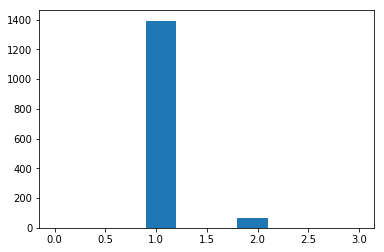

In [134]:
plt.hist(train['KitchenAbvGr']) #remove
plt.show()

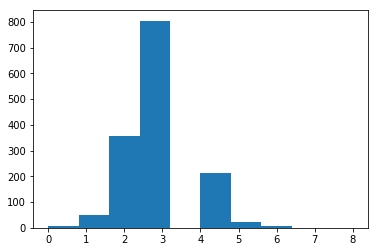

In [135]:
plt.hist(train['BedroomAbvGr']) #remove
plt.show()

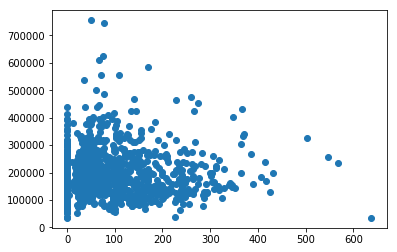

In [136]:
plt.scatter(train['OpenPorchSF']+train['EnclosedPorch'], train['SalePrice'])
plt.show()

In [137]:
num_features = ['LotFrontage', 'LotArea', 'OverallQual','YearBuilt', 'YearRemodAdd', 'MasVnrArea','totSF', 'totBath','TotRmsAbvGrd', 
'Fireplaces', 'GarageCars']

In [138]:
train.select_dtypes(['object']).columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [139]:
cat_features = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition']

C:\Users\Matteo.Belloni\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


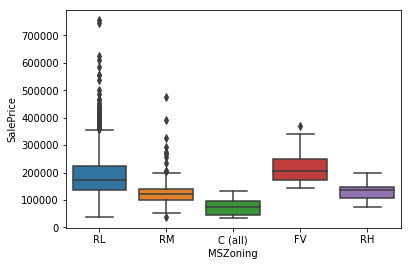

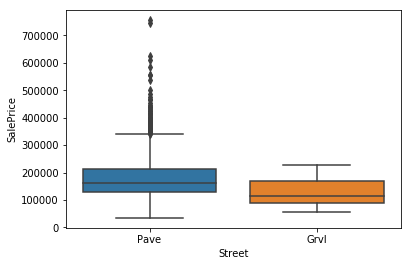

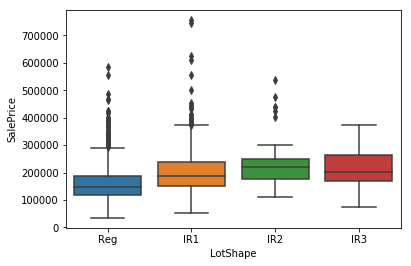

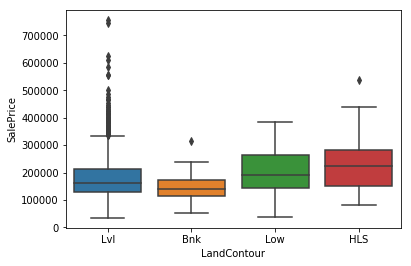

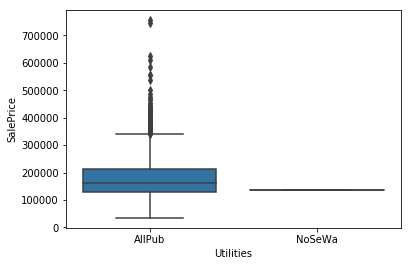

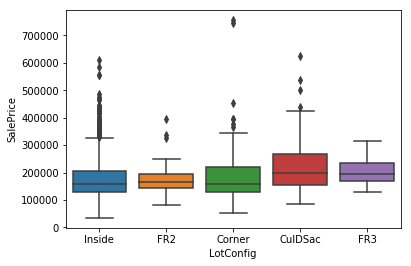

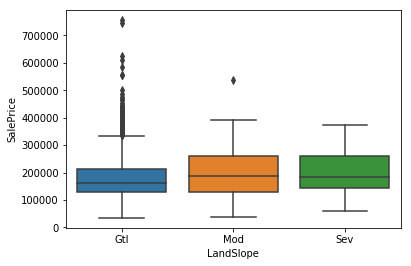

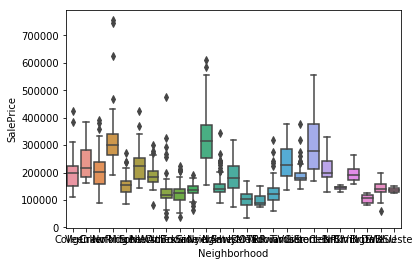

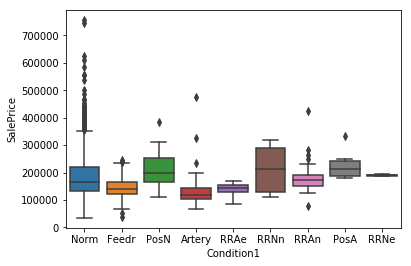

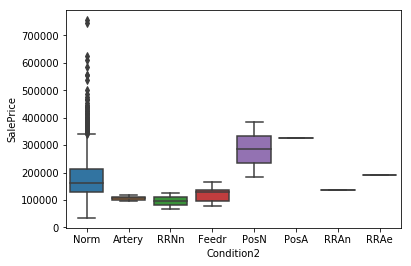

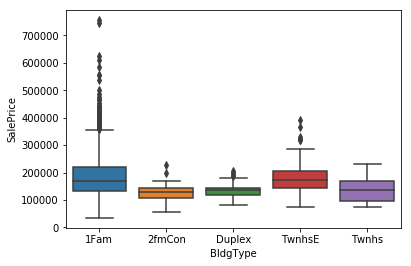

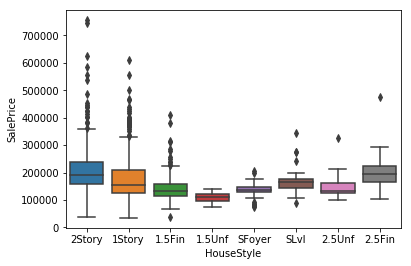

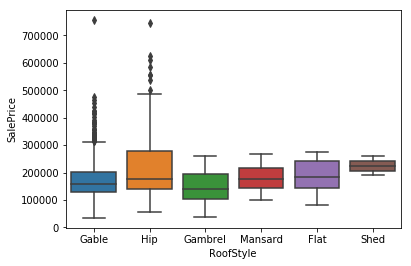

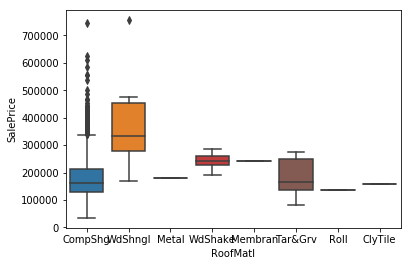

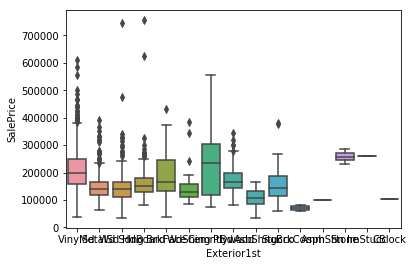

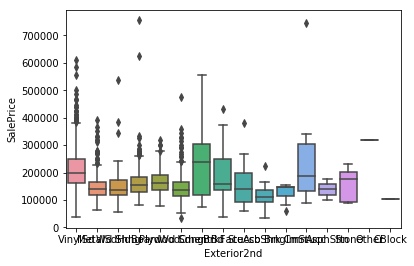

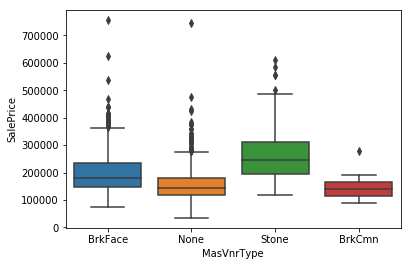

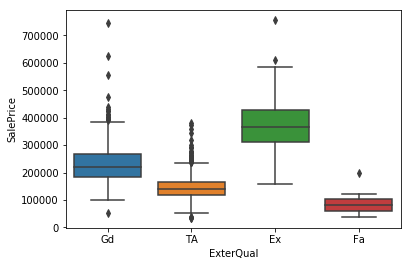

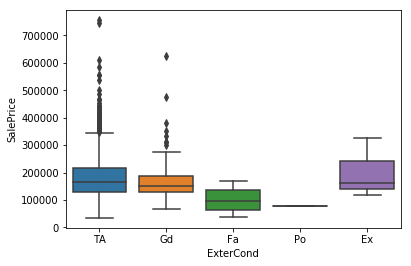

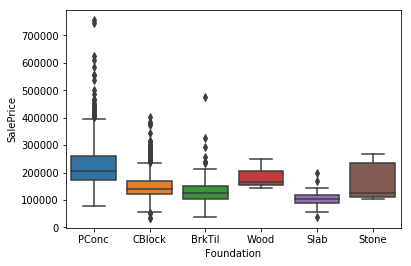

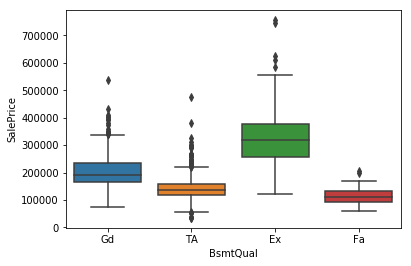

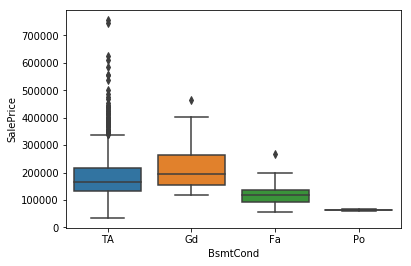

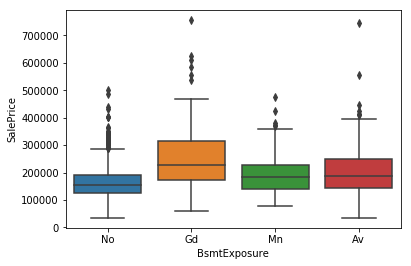

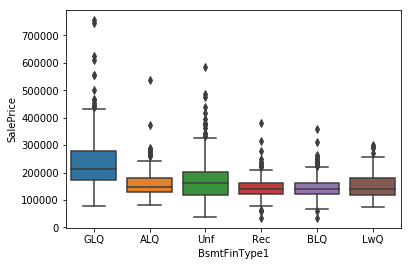

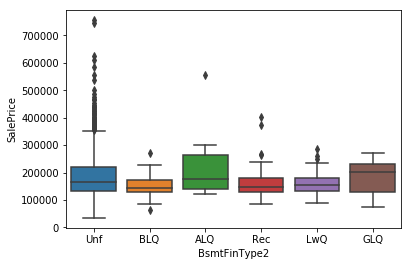

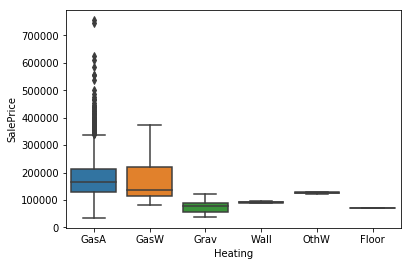

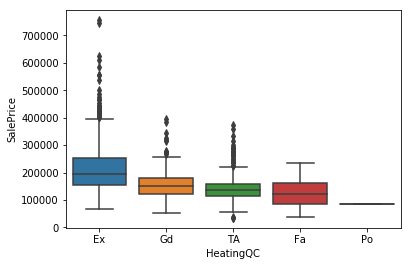

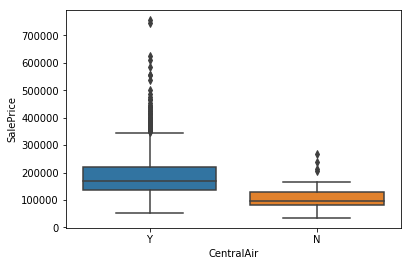

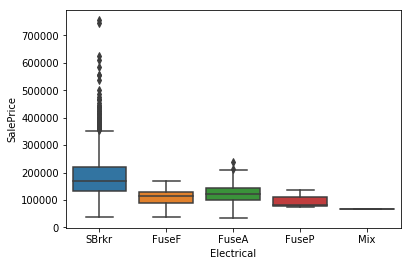

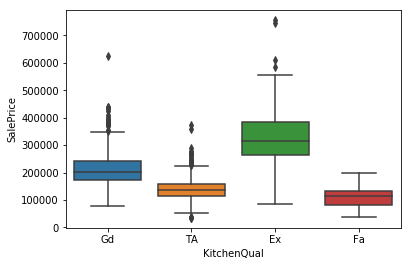

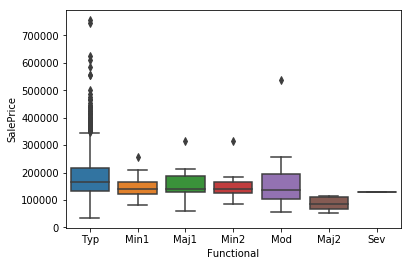

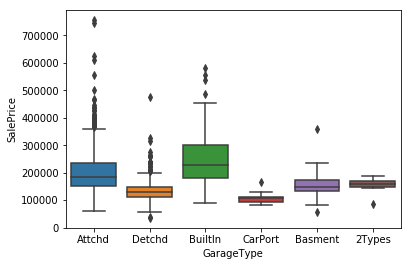

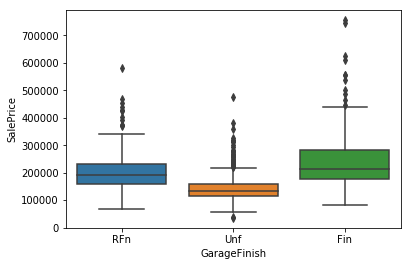

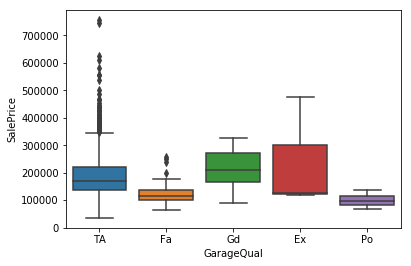

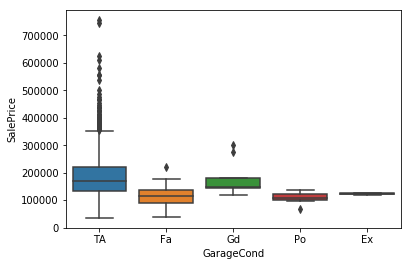

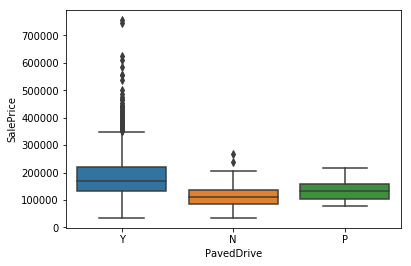

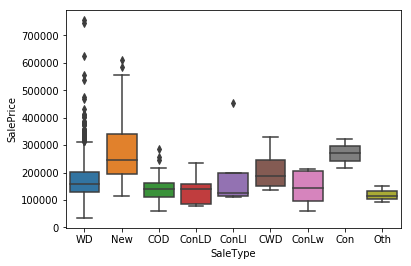

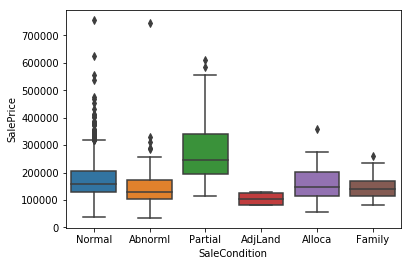

In [32]:
for cat in cat_features:
    plt.figure()
    sns.boxplot(x = cat, y = 'SalePrice', data = train)

In [140]:
cat_features = ['MSZoning', 'Street','Neighborhood','MasVnrType', 'ExterQual','BsmtQual',
                'HeatingQC', 'CentralAir','GarageFinish', 'PavedDrive', 'SaleType']

In [141]:
train['ExterQual'].fillna('NA', inplace = True)
test['ExterQual'].fillna('NA', inplace = True)
dict_qual = {'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4, 'Ex':5}
train['ExterQual'] = train['ExterQual'].map(dict_qual)
test['ExterQual'] = test['ExterQual'].map(dict_qual)
train['BsmtQual'].fillna('NA', inplace = True)
test['BsmtQual'].fillna('NA', inplace = True)
train['BsmtQual'] = train['BsmtQual'].map(dict_qual)
test['BsmtQual'] = test['BsmtQual'].map(dict_qual)
train['HeatingQC'] = train['HeatingQC'].map(dict_qual)
test['HeatingQC'] = test['HeatingQC'].map(dict_qual)
dict_ca = {'Y':1, 'N':0}
train['CentralAir'] = train['CentralAir'].map(dict_ca)
test['CentralAir'] = test['CentralAir'].map(dict_ca)
dict_ga = {'Unf':0, 'RFn':1, 'Fin':2}
train['GarageFinish'] = train['GarageFinish'].map(dict_ga)
test['GarageFinish'] = test['GarageFinish'].map(dict_ga)
dict_pd = {'Y':2, 'N':0, 'P':1}
train['PavedDrive'] = train['PavedDrive'].map(dict_pd)
test['PavedDrive'] = test['PavedDrive'].map(dict_pd)

In [142]:
cat_features = ['MSZoning','Neighborhood','SaleType']
num_features = num_features + ['ExterQual','BsmtQual','HeatingQC', 'CentralAir', 'GarageFinish', 'PavedDrive']

In [143]:
submission = test[['Id']]

In [144]:
train = train[num_features + cat_features + ['SalePrice']]
test = test[num_features + cat_features]

In [145]:
cat_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'most_frequent')),
                                    ('onehot', OneHotEncoder(drop='first'))])
num_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy='median')),
                                    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers = [('num', num_transformer, num_features),
                                                 ('cat', cat_transformer, cat_features)])

In [146]:
X_train = train[num_features + cat_features]
y_train = train['SalePrice']

In [147]:
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size = 0.1)

In [148]:
X_test = test[num_features + cat_features]
#y_test = np.log(test['SalePrice'])

In [149]:
lr = Pipeline(steps = [('preprocessor',preprocessor), ('regressor',LinearRegression())])
lr.fit(X_train_train, y_train_train)
pred_train = lr.predict(X_train_train)
pred_val = lr.predict(X_train_val)
print(r2_score(y_train_train, pred_train))
print(np.sqrt(mean_squared_error(y_train_train, pred_train)))
print(r2_score(y_train_val, pred_val))
print(np.sqrt(mean_squared_error(y_train_val, pred_val)))

0.832853797320006
32583.8561233566
0.8379077044133562
30881.03045841248


In [95]:
param_grid = {
    'regressor__n_estimatores': [10, 100, 200],
    'regressor__max_depth':[6,12,24] 
    }

xgb = Pipeline(steps = [('preprocessor',preprocessor), ('regressor',XGBRegressor())])

grid_xgb = GridSearchCV(xgb, param_grid, cv=10, iid=False)
grid_xgb.fit(X_train_train, y_train_train)

grid_xgb.best_params_

C:\Users\Matteo.Belloni\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'regressor__max_depth': 6, 'regressor__n_estimatores': 10}

In [150]:
xgb = Pipeline(steps = [('preprocessor',preprocessor), ('regressor',XGBRegressor())])
xgb.fit(X_train_train, y_train_train)
pred_train = xgb.predict(X_train_train)
pred_val = xgb.predict(X_train_val)
print(r2_score(y_train_train, pred_train))
print(np.sqrt(mean_squared_error(y_train_train, pred_train)))
print(r2_score(y_train_val, pred_val))
print(np.sqrt(mean_squared_error(y_train_val, pred_val)))

0.948446861621468
18095.96620687697
0.8914656511920476
25269.357503828793


In [151]:
lightgbm = Pipeline(steps = [('preprocessor',preprocessor), ('regressor',LGBMRegressor())])
lightgbm.fit(X_train_train, y_train_train)
pred_train = lightgbm.predict(X_train_train)
pred_val = lightgbm.predict(X_train_val)
print(r2_score(y_train_train, pred_train))
print(np.sqrt(mean_squared_error(y_train_train, pred_train)))
print(r2_score(y_train_val, pred_val))
print(np.sqrt(mean_squared_error(y_train_val, pred_val)))

0.9618809217569014
15560.566982279335
0.8845888787927872
26057.60085581057


In [46]:
catb = Pipeline(steps = [('preprocessor',preprocessor), ('regressor',CatBoostRegressor())])
catb.fit(X_train_train, y_train_train)
pred_train = catb.predict(X_train_train)
pred_val = catb.predict(X_train_val)
print(r2_score(y_train_train, pred_train))
print(np.sqrt(mean_squared_error(y_train_train, pred_train)))
print(r2_score(y_train_val, pred_val))
print(np.sqrt(mean_squared_error(y_train_val, pred_val)))

0:	learn: 193114.5560193	total: 265ms	remaining: 4m 24s
1:	learn: 187922.3014804	total: 385ms	remaining: 3m 11s
2:	learn: 182980.6854290	total: 525ms	remaining: 2m 54s
3:	learn: 178151.2808079	total: 631ms	remaining: 2m 37s
4:	learn: 173355.8519475	total: 696ms	remaining: 2m 18s
5:	learn: 168623.0100179	total: 833ms	remaining: 2m 18s
6:	learn: 164101.9036930	total: 965ms	remaining: 2m 16s
7:	learn: 159802.4036588	total: 1.12s	remaining: 2m 18s
8:	learn: 155540.1694123	total: 1.29s	remaining: 2m 22s
9:	learn: 151445.5633982	total: 1.45s	remaining: 2m 23s
10:	learn: 147480.9520790	total: 1.63s	remaining: 2m 26s
11:	learn: 143680.8051960	total: 1.78s	remaining: 2m 26s
12:	learn: 140008.2311511	total: 1.92s	remaining: 2m 25s
13:	learn: 136476.1836828	total: 2.03s	remaining: 2m 22s
14:	learn: 133002.9498025	total: 2.15s	remaining: 2m 21s
15:	learn: 129653.1812887	total: 2.28s	remaining: 2m 20s
16:	learn: 126374.8385128	total: 2.44s	remaining: 2m 20s
17:	learn: 123244.7236016	total: 2.55s	re

147:	learn: 28364.0908813	total: 18s	remaining: 1m 43s
148:	learn: 28343.8704714	total: 18.1s	remaining: 1m 43s
149:	learn: 28259.1137738	total: 18.2s	remaining: 1m 43s
150:	learn: 28224.7836687	total: 18.4s	remaining: 1m 43s
151:	learn: 28142.6969422	total: 18.5s	remaining: 1m 43s
152:	learn: 28043.1308718	total: 18.6s	remaining: 1m 43s
153:	learn: 27914.8565019	total: 18.8s	remaining: 1m 43s
154:	learn: 27888.1973503	total: 18.9s	remaining: 1m 43s
155:	learn: 27836.0076530	total: 19s	remaining: 1m 42s
156:	learn: 27800.6865791	total: 19.1s	remaining: 1m 42s
157:	learn: 27751.8952175	total: 19.2s	remaining: 1m 42s
158:	learn: 27741.7590887	total: 19.3s	remaining: 1m 42s
159:	learn: 27629.5435568	total: 19.4s	remaining: 1m 42s
160:	learn: 27544.3214818	total: 19.5s	remaining: 1m 41s
161:	learn: 27472.4369623	total: 19.6s	remaining: 1m 41s
162:	learn: 27450.9689260	total: 19.8s	remaining: 1m 41s
163:	learn: 27440.9081807	total: 19.8s	remaining: 1m 41s
164:	learn: 27398.5866696	total: 19

292:	learn: 24339.4275469	total: 34.5s	remaining: 1m 23s
293:	learn: 24319.0895429	total: 34.6s	remaining: 1m 23s
294:	learn: 24295.5498169	total: 34.7s	remaining: 1m 22s
295:	learn: 24289.5615934	total: 34.8s	remaining: 1m 22s
296:	learn: 24286.6270621	total: 34.9s	remaining: 1m 22s
297:	learn: 24255.1843540	total: 35s	remaining: 1m 22s
298:	learn: 24250.6149915	total: 35.1s	remaining: 1m 22s
299:	learn: 24244.3055912	total: 35.3s	remaining: 1m 22s
300:	learn: 24238.9423438	total: 35.3s	remaining: 1m 22s
301:	learn: 24211.9961684	total: 35.5s	remaining: 1m 21s
302:	learn: 24206.6503983	total: 35.6s	remaining: 1m 21s
303:	learn: 24203.2780521	total: 35.7s	remaining: 1m 21s
304:	learn: 24161.0607424	total: 35.8s	remaining: 1m 21s
305:	learn: 24152.6772932	total: 35.9s	remaining: 1m 21s
306:	learn: 24116.2865005	total: 36s	remaining: 1m 21s
307:	learn: 24113.7388153	total: 36.1s	remaining: 1m 21s
308:	learn: 24108.9293607	total: 36.3s	remaining: 1m 21s
309:	learn: 24099.1317629	total: 36

437:	learn: 22441.2394666	total: 54.1s	remaining: 1m 9s
438:	learn: 22439.0216790	total: 54.2s	remaining: 1m 9s
439:	learn: 22438.4410260	total: 54.3s	remaining: 1m 9s
440:	learn: 22437.6275802	total: 54.4s	remaining: 1m 8s
441:	learn: 22435.2655319	total: 54.6s	remaining: 1m 8s
442:	learn: 22421.8859679	total: 54.7s	remaining: 1m 8s
443:	learn: 22413.7242454	total: 54.8s	remaining: 1m 8s
444:	learn: 22402.9614696	total: 55s	remaining: 1m 8s
445:	learn: 22402.2964791	total: 55.1s	remaining: 1m 8s
446:	learn: 22375.7965211	total: 55.2s	remaining: 1m 8s
447:	learn: 22371.1785566	total: 55.4s	remaining: 1m 8s
448:	learn: 22359.3938112	total: 55.5s	remaining: 1m 8s
449:	learn: 22358.9964879	total: 55.7s	remaining: 1m 8s
450:	learn: 22344.8643975	total: 55.8s	remaining: 1m 7s
451:	learn: 22333.7905183	total: 55.9s	remaining: 1m 7s
452:	learn: 22332.7934329	total: 56s	remaining: 1m 7s
453:	learn: 22327.5646326	total: 56.1s	remaining: 1m 7s
454:	learn: 22326.7487244	total: 56.2s	remaining: 1m

585:	learn: 21486.1066838	total: 1m 13s	remaining: 52.1s
586:	learn: 21484.5086580	total: 1m 13s	remaining: 52s
587:	learn: 21483.8861434	total: 1m 13s	remaining: 51.8s
588:	learn: 21478.2950420	total: 1m 14s	remaining: 51.7s
589:	learn: 21470.8911441	total: 1m 14s	remaining: 51.6s
590:	learn: 21469.6489815	total: 1m 14s	remaining: 51.4s
591:	learn: 21467.5056818	total: 1m 14s	remaining: 51.3s
592:	learn: 21466.5300944	total: 1m 14s	remaining: 51.2s
593:	learn: 21465.6822750	total: 1m 14s	remaining: 51.1s
594:	learn: 21464.0306662	total: 1m 14s	remaining: 50.9s
595:	learn: 21463.2855062	total: 1m 14s	remaining: 50.8s
596:	learn: 21461.7460069	total: 1m 15s	remaining: 50.7s
597:	learn: 21461.0519713	total: 1m 15s	remaining: 50.6s
598:	learn: 21460.4642811	total: 1m 15s	remaining: 50.4s
599:	learn: 21459.6620318	total: 1m 15s	remaining: 50.3s
600:	learn: 21459.0640863	total: 1m 15s	remaining: 50.2s
601:	learn: 21457.5485270	total: 1m 15s	remaining: 50.1s
602:	learn: 21439.7908498	total: 

731:	learn: 20897.7624550	total: 1m 38s	remaining: 36.2s
732:	learn: 20897.5118616	total: 1m 38s	remaining: 36s
733:	learn: 20895.7627394	total: 1m 39s	remaining: 35.9s
734:	learn: 20892.8884779	total: 1m 39s	remaining: 35.8s
735:	learn: 20892.2541707	total: 1m 39s	remaining: 35.7s
736:	learn: 20870.7366405	total: 1m 39s	remaining: 35.5s
737:	learn: 20870.0126009	total: 1m 39s	remaining: 35.4s
738:	learn: 20859.7618768	total: 1m 39s	remaining: 35.3s
739:	learn: 20858.9233429	total: 1m 39s	remaining: 35.1s
740:	learn: 20858.9226974	total: 1m 40s	remaining: 35s
741:	learn: 20858.2057811	total: 1m 40s	remaining: 34.8s
742:	learn: 20857.5251850	total: 1m 40s	remaining: 34.7s
743:	learn: 20857.4476980	total: 1m 40s	remaining: 34.6s
744:	learn: 20857.3719879	total: 1m 40s	remaining: 34.4s
745:	learn: 20856.7330196	total: 1m 40s	remaining: 34.3s
746:	learn: 20852.9348214	total: 1m 40s	remaining: 34.1s
747:	learn: 20852.6011793	total: 1m 40s	remaining: 34s
748:	learn: 20852.0037369	total: 1m 4

876:	learn: 20570.7683962	total: 2m 3s	remaining: 17.4s
877:	learn: 20568.4147708	total: 2m 4s	remaining: 17.3s
878:	learn: 20568.3990174	total: 2m 4s	remaining: 17.1s
879:	learn: 20567.1507865	total: 2m 4s	remaining: 17s
880:	learn: 20567.0455279	total: 2m 4s	remaining: 16.9s
881:	learn: 20566.9910569	total: 2m 5s	remaining: 16.7s
882:	learn: 20565.5238745	total: 2m 5s	remaining: 16.6s
883:	learn: 20558.5001735	total: 2m 5s	remaining: 16.5s
884:	learn: 20558.4991111	total: 2m 5s	remaining: 16.3s
885:	learn: 20556.7406999	total: 2m 5s	remaining: 16.2s
886:	learn: 20554.1505269	total: 2m 6s	remaining: 16.1s
887:	learn: 20553.0170296	total: 2m 6s	remaining: 15.9s
888:	learn: 20552.9488012	total: 2m 6s	remaining: 15.8s
889:	learn: 20552.9098277	total: 2m 6s	remaining: 15.7s
890:	learn: 20550.8042763	total: 2m 6s	remaining: 15.5s
891:	learn: 20550.4414294	total: 2m 7s	remaining: 15.4s
892:	learn: 20549.2946484	total: 2m 7s	remaining: 15.3s
893:	learn: 20546.0074859	total: 2m 7s	remaining: 

In [152]:
xgb = Pipeline(steps = [('preprocessor',preprocessor), ('regressor',XGBRegressor(n_estimatores = 10))])
xgb.fit(X_train, y_train)
pred = xgb.predict(X_train)
print(r2_score(y_train, pred))
print(np.sqrt(mean_squared_error(y_train, pred)))

0.9457816075597633
18491.72621898977


In [153]:
pred_test = xgb.predict(X_test)

In [154]:
len(pred_test), submission['Id'].shape[0]

(1459, 1459)

In [155]:
submission['SalePrice'] = pred_test
submission.head()

,Id,SalePrice
0,1461,110667.664062
1,1462,152940.390625
2,1463,184846.484375
3,1464,180092.718750
4,1465,197305.953125


In [ ]:
submission.to_csv("submission_matteo_2.csv", index=False)